In [ ]:
import zipfile
import os
import json
import pandas as pd
import json
import os
import pandas as pd


zip_file_path = 'archive.zip' # Path to the ZIP file
extracted_folder = 'extracted_contents' # Directory to extract files

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

In [ ]:
def process_and_filter_json_files(folder_path):
    combined_data = []
    invalid_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as json_file:
                    try:
                        data = json.load(json_file)
                        # Extract year from the data
                        year = int(data['year'])
                        if 2010 <= year <= 2016:
                            # Append relevant data to the combined list
                            combined_data.append(data)
                    except json.JSONDecodeError:
                        invalid_files.append(file_path)
    if invalid_files:
        print("Invalid JSON files:")
        for file_path in invalid_files:
            print(file_path)
    return combined_data


combined_data = process_and_filter_json_files(extracted_folder)

In [ ]:
def extract_financial_metrics(json_data):
    bs_section = json_data.get('data', {}).get('bs', [])
    ic_section = json_data.get('data', {}).get('ic', [])

    # Initialize variables to store attribute values
    total_liabilities = total_current_liabilities = retained_earnings = total_current_assets = net_sales = None

    # Extract values for each attribute
    for item in bs_section:
        if item['label'] == 'Total liabilities':
            total_liabilities = item['value']
        elif item['label'] == 'Total current liabilities':
            total_current_liabilities = item['value']
        elif item['label'] == 'Total current assets':
            total_current_assets = item['value']
        elif item['label'] == 'Retained earnings':
            retained_earnings = item['value']

    for item in ic_section:
        if item['label'] == 'Net sales':
            net_sales = item['value']

    return total_liabilities, total_current_liabilities, total_current_assets, retained_earnings, net_sales

def process_and_extract_metrics(folder_path):
    extracted_metrics = []
    invalid_files = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as json_file:
                    try:
                        data = json.load(json_file)
                        symbol = data.get('symbol')
                        year = data.get('year')
                        quarter = data.get('quarter')

                        # Extract financial metrics from each JSON file
                        metrics = extract_financial_metrics(data)
                        extracted_metrics.append((symbol, year, quarter) + metrics)
                    except json.JSONDecodeError:
                        invalid_files.append(file_path)

    if invalid_files:
        print("Invalid JSON files:")
        for file_path in invalid_files:
            print(file_path)

    return extracted_metrics


extracted_metrics = process_and_extract_metrics(extracted_folder)

# Convert to DataFrame
columns = ['Symbol', 'Year', 'Quarter', 'Total Liabilities', 'Total Current Liabilities', 'Total Current Assets', 'Retained Earnings', 'Net Sales']
df = pd.DataFrame(extracted_metrics, columns=columns)

In [111]:
df

,Symbol,Year,Quarter,Total Liabilities,Total Current Liabilities,Total Current Assets,Retained Earnings,Net Sales
0,ICCC,2013,Q1,None,None,None,None,None
1,LGDI,2013,Q1,None,None,None,None,None
2,LII,2013,Q1,None,None,None,742400000,668400000
3,HLB,2013,Q1,None,None,7387285,None,None
4,AMIN,2013,Q1,None,5042731,None,None,None
...,...,...,...,...,...,...,...,...
278432,CE,2010,Q2,None,None,None,None,2905000000
278433,LEG,2010,Q2,None,571600000,1307000000,2032300000,1690700000
278434,RHI,2010,Q2,385449000,357659000,897623000,N/A,None
278435,PNRA,2010,Q2,None,None,None,None,None


In [98]:
filtered_df = df.dropna(subset=['Total Liabilities', 'Total Current Liabilities', 'Total Current Assets','Retained Earnings', 'Net Sales'])

filtered_df['Year'] = filtered_df['Year'].astype(int)
filtered_df = filtered_df[(filtered_df['Year'] >= 2010) & (filtered_df['Year'] <= 2016)]


# Output filtered DataFrame
print(filtered_df)

              Symbol  Year Quarter Total Liabilities  \
13567           JAKK  2011      Q2         212559000   
14787            NPO  2011      Q2         687000000   
15685           QKLS  2011      Q2          74607386   
15734           OFIX  2011      Q2         349116000   
17927   CK0001357787  2011      Q2         760800000   
...              ...   ...     ...               ...   
277561           MSA  2010      Q2         467053000   
277714           ENS  2010      Q1         820787000   
277820           WAB  2010      Q2         825244000   
277954          TECD  2010      Q2        3564304000   
278101            CR  2010      Q2        1770855000   

       Total Current Liabilities Total Current Assets Retained Earnings  \
13567                  115660000            488502000         113549000   
14787                  333200000            405900000          88100000   
15685                   74607386            100192977           4649112   
15734                  1332

<ipython-input-98-9f385e7afe25>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = filtered_df['Year'].astype(int)


In [105]:
# Get summary details for each column including non-numeric columns
summary_details = filtered_df['Net Sales'].describe(include='all')

print(summary_details)


count            66
unique           64
top       266833256
freq              2
Name: Net Sales, dtype: int64


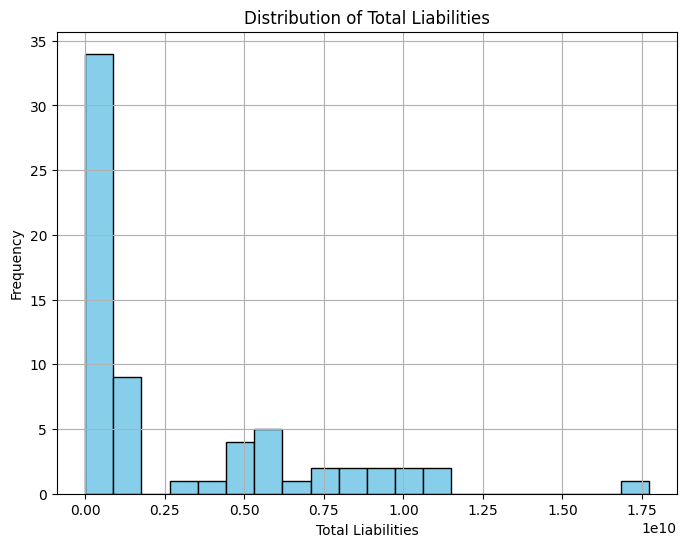

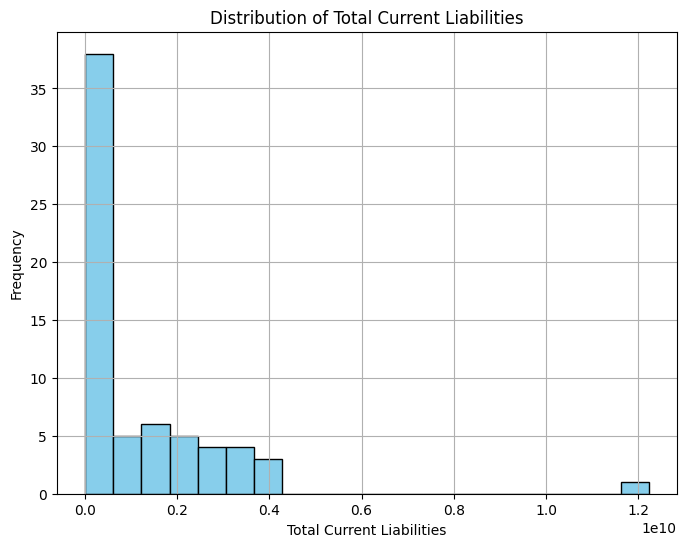

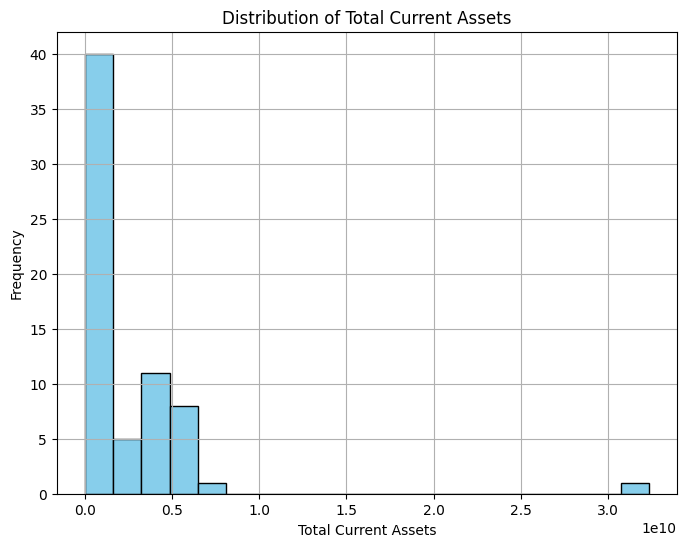

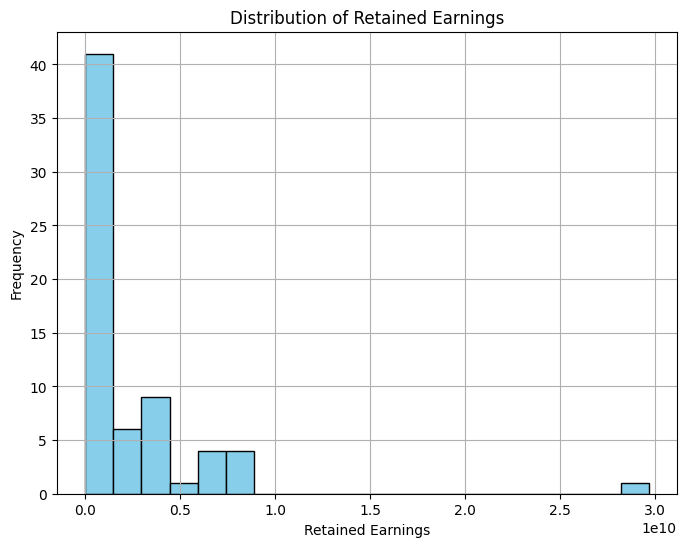

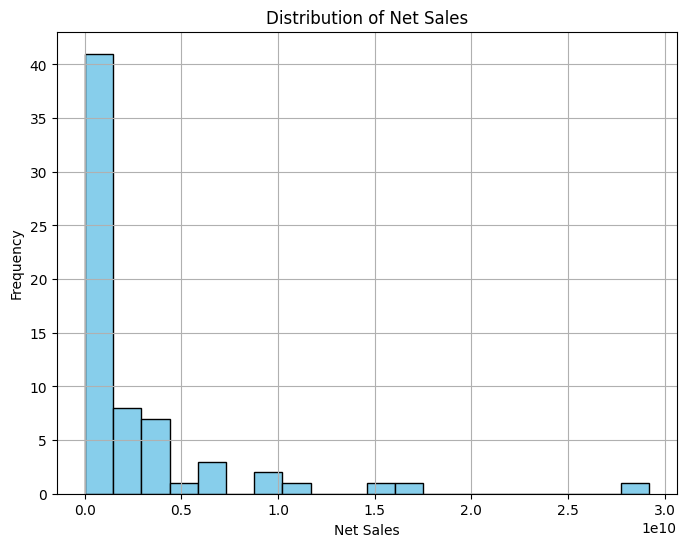

In [110]:
import matplotlib.pyplot as plt

# Filter DataFrame for selected numerical columns
selected_columns = ['Total Liabilities', 'Total Current Liabilities', 'Total Current Assets','Retained Earnings', 'Net Sales']
selected_df = filtered_df[selected_columns]

# Plot distribution of each selected numerical feature
for column in selected_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(selected_df[column].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

